In [88]:
import os
# os.chdir(os.path.dirname(os.path.abspath(__file__)))
from glob import glob
import re, numpy as np

toplot = sorted(glob('./measures_*spl_averaged*.csv'))
# print("partial",toplot)

toplot = {int(re.search(r'_(\d\d+)spl',x).group(1)):x for x in toplot}
print(toplot)

modded_plugin_toplot = sorted(glob('./measures_MOD_old_Plugin_averaged_*.csv'))
modded_plugin_toplot = {int(re.search(r'_(\d\d+)\.csv',x).group(1)):x for x in modded_plugin_toplot}
print('modded_plugin_toplot',modded_plugin_toplot)

VERTICAL = False

{1024: '.\\measures_1024spl_averaged.csv', 256: '.\\measures_256spl_averaged.csv', 64: '.\\measures_64spl_averaged.csv'}
modded_plugin_toplot {256: '.\\measures_MOD_old_Plugin_averaged_256.csv', 64: '.\\measures_MOD_old_Plugin_averaged_64.csv'}


In [89]:
import pandas as pd
# Load data
dataDict = {k:pd.read_csv(v) for k,v in toplot.items()}
# Convert to a single dataframe, where the key is checked against the 'spl' column of the item (pd dataframe)
for key,item in dataDict.items():
    for spl in item['spl']:
        # print(spl, key)
        assert spl == key, 'spl column does not match key ({} != {})'.format(spl, key)
# Now that we are sure, concat all the dataframes into a single one
data = pd.concat(dataDict.values())

#### Repeat for latest csvs that contain data from modded plugin (removed lower buffersize cap of 512)
modded_dataDict = {k:pd.read_csv(v) for k,v in modded_plugin_toplot.items()}
for key,item in modded_dataDict.items():
    for spl in item['spl']:
        # print(spl, key)
        assert spl == key, 'spl column does not match key ({} != {})'.format(spl, key)
# Now that we are sure, concat all the dataframes into a single one
moddedData = pd.concat(modded_dataDict.values())
# To moddeddata, add all the data from "data" that has spl >= 512 which are good for the comparison with modded plugin
# As the performance of those configs do not change
moddedData = pd.concat([moddedData, data[data.spl >= 512]])
# Finally, add all data from new plugin that has spl < 512
moddedData = pd.concat([moddedData, data[(data['plugin'] == 'new') & (data['spl'] < 512)]])

# ensure that there are rows with spl < 512 and plugin = 'old'
assert moddedData[(moddedData.spl < 512) & (moddedData['plugin'] == 'old')].shape[0] == 0, 'There are rows with spl < 512 and plugin = old'
# Rename all 
moddedData['plugin'] = moddedData['plugin'].replace({'MODOld':'old'})

In [90]:
PERPLOT_TITLE_SIZE = 10

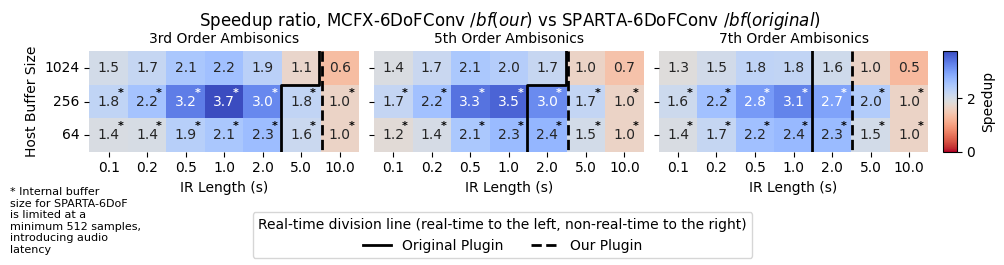

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

def add_clipped_figtext(fig, x, y, text, width=0.5, height=0.5, wrap_width=20):
        """
        Add wrapped text to a figure (outside axes) within a clipped rectangular region.
        
        Parameters:
        -----------
        fig : matplotlib.figure.Figure
            The figure to add the text to
        x, y : float
            The coordinates in figure fraction (0-1) for the bottom-left corner
        text : str
            The text to display
        width, height : float
            The width and height of the clipping rectangle in figure fraction
        wrap_width : int
            The number of characters at which to wrap the text
        """
        # Create clipping rectangle in figure coordinates
        from matplotlib import patches
        from matplotlib.transforms import Bbox
        import textwrap

        # clip_rect = patches.Rectangle(
        #     (x, y), width, height,
        #     transform=fig.transFigure,
        #     clip_on=False,
        #     fill=False,
        #     linestyle='--',
        #     alpha=0.5
        # )
        
        # # Add the clipping rectangle to the figure
        # fig.patches.append(clip_rect)
        
        # Wrap the text
        wrapped_text = textwrap.fill(text, width=wrap_width)
        
        # Create text with clipping
        text_artist = plt.figtext(
            x, y, wrapped_text,
            # clip_path=clip_rect,
            # clip_box=Bbox([[x, y], [x + width, y + height]]),
            verticalalignment='bottom',
            color='k',
            size=8
        )
        
        return text_artist

def draw_real_time_crosslines(axes, idx, rtlinesList, linestyle='dashed', xoffset=0, VERBOSE=False):
    #Real-time line for old plugin
    printverbose = lambda txt,*args, **kwargs: print(txt,*args, **kwargs) if VERBOSE else None
    assert len(rtlinesList) == 3, 'rtlinesList should have 3 elements'
    assert all([isinstance(x,list) for x in rtlinesList]), 'rtlinesList should contain lists'

    # if idx == 0:
    #     axes[idx].plot([6,6+alloffset,6+alloffset], [0, 2, 3], color='black', linewidth=2, linestyle='dashed')
    # elif idx == 1:
    #     axes[idx].plot([5,5+alloffset,5+alloffset], [0, 2, 3], color='black', linewidth=2, linestyle='dashed')
    # elif idx == 2:
    #     axes[idx].plot([5,5,5], [0, 2, 3], color='black', linewidth=2, linestyle='dashed')
    for idx in range(len(rtlinesList)):
        cur_rtlines = rtlinesList[idx]
        printverbose('Currtlines', cur_rtlines)
        MAX_Y = int(max(axes[idx].get_ylim()))
        assert len(cur_rtlines) == 3, 'rtlinesList should have 3 elements because THEREARETHREEBUFFERSIZES'
        x = [cur_rtlines[0]]
        y = [MAX_Y]
        for idx2 in range(len(cur_rtlines)):
            if (len(x) ==0 and len(y) == 0) or cur_rtlines[idx2] == x[-1]:
                printverbose('cur_rtlines[idx2] == x[-1] or empty')
                x.append(cur_rtlines[idx2])
                y.append(MAX_Y-1-idx2)
                printverbose(f'Appending ({x[-1]},{y[-1]})')
            else:
                printverbose('!=')
                x.append(cur_rtlines[idx2])
                y.append(y[-1])
                printverbose(f'Appending ({x[-1]},{y[-1]})')
                x.append(cur_rtlines[idx2])
                y.append(MAX_Y-1-idx2)
                printverbose(f'Appending ({x[-1]},{y[-1]})')

        printverbose(f'For idx {idx} x is {x} and y is {[int(e) for e in y]}')
        # Apply offset used to distinguish the lines
        x = [e+xoffset for e in x]
        axes[idx].plot(x,y, color='black', linewidth=2, linestyle=linestyle)
            



def draw_asteriscs_oldplugin_buffersize(ir_lengths,buffer_sizes,ax, asterisk_colors=None):
        for xtp in range(len(ir_lengths)):
            for ytp in range(len([bs for bs in buffer_sizes if bs < 512])):
                ax.text(xtp+.8, ytp+.67,"*", color='black' if asterisk_colors is None else asterisk_colors[ytp][xtp], ha='center', zorder=11, size=8, weight='bold')


numeral_to_ordinal = lambda n: f'{n}{"tsnrhtdd"[((n//10%10!=1)*(n%10<4)*n%10)::4]}'

# Create performance ratio heatmap
def create_performance_heatmap(data, title=False, asterisks=True, asterisk_colors=None, colormap = 'RdYlGn', rtlinesOld=None, rtlinesNew=None,labelOld='Original Plugin', labelNew='Our Plugin', verbose_rtlines=False,titlesize=12):
    # newPlugin_data, oldPlugin_data, ambisonics_orders, buffer_sizes, ir_lengths, 

    channel_numbers = sorted(data['channels'].unique())
    buffer_sizes = sorted(data['spl'].unique())
    ir_lengths = sorted(data['irlen_s'].unique())
    ambisonics_orders = np.sqrt(channel_numbers)-1

    # print('channel_numbers',channel_numbers)
    # print('buffer_sizes',buffer_sizes)
    # print('ir_lengths',ir_lengths)
    # print('ambisonics_orders',ambisonics_orders)
    

    # print(channel_numbers, ambisonics_orders, buffer_sizes, ir_lengths)
    # oldPlugin_data should be in the shape of (channel_numbers, buffer_sizes, ir_lengths) and taken from data
    def get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths):
        plottable = np.zeros((len(channel_numbers), len(buffer_sizes), len(ir_lengths)))
        assert plottable.shape == (3,3,7), "error, shape is %s"%(str(plottable.shape))
        for idx, channels in enumerate(channel_numbers):
            for idx2, buffer_size in enumerate(buffer_sizes):
                for idx3, ir_length in enumerate(ir_lengths):
                    tosave = data[(data['channels'] == channels) & (data['spl'] == buffer_size) & (data['irlen_s'] == ir_length) & (data['plugin'] == plugin)]['X_mean'].values[0]
                    plottable[idx, idx2, idx3] = tosave
        return plottable
    
    oldPlugin_data = get_plottable(data, 'old', channel_numbers, buffer_sizes, ir_lengths)
    newPlugin_data = get_plottable(data, 'new', channel_numbers, buffer_sizes, ir_lengths)


    # Calculate performance ratio
    performance_ratio = newPlugin_data/oldPlugin_data
    
    # Create figure with subplots for different ambisonic orders
    # fig, axes = plt.subplots(1, len(ambisonics_orders), figsize=(9, 1+len(buffer_sizes)/3*1.5), sharey=True)

    if not VERTICAL:
        fig = plt.figure(figsize=(10, 2.5))  # Slightly wider to accommodate colorbar
        from matplotlib import gridspec
        gs = gridspec.GridSpec(1, len(channel_numbers) + 1, width_ratios=[1]*len(channel_numbers) + [0.05])
        axes = [plt.subplot(gs[i]) for i in range(len(channel_numbers))]
    else:
        fig = plt.figure(figsize=(6, 8))
        from matplotlib import gridspec
        gs = gridspec.GridSpec(len(channel_numbers), 1, height_ratios=[1]*len(channel_numbers))
        axes = [plt.subplot(gs[i]) for i in range(len(channel_numbers))]
        


    if title:
        fig.suptitle(title,fontsize=titlesize)
    
    # Plot heatmap for each ambisonics order
    for idx, order in enumerate(ambisonics_orders):
        # Extract data for specific ambisonics order
        data = performance_ratio[idx, :, :]

        # Create heatmap
        sns.heatmap(data, 
                    ax=axes[idx], 
                    cmap=colormap,  # Red-Yellow-Green reversed (red = worse, green = better)
                    # cbar=idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
                    cbar=False,
                    annot=True, 
                    fmt='.1f',
                    vmin=0, 
                    # square=True,
                    vmax=performance_ratio.max(), #round_to_next_half(max(performance_ratio.max(), 1.5)),
                    center=1.3,
                    # cbar_kws={'label': 'Performance Ratio'} if idx == len(ambisonics_orders)-1 else {},
                    annot_kws={'size': 10, 'rotation': 0},
                    )
        
        # if draw_rtlines:
        #     draw_real_time_crosslines(axes, idx,)

        if idx == len(ambisonics_orders)-1:
            if rtlinesOld != None:
                draw_real_time_crosslines(axes, idx,rtlinesOld, linestyle='solid', xoffset=-0.03, VERBOSE=verbose_rtlines)
            if rtlinesNew != None:
                draw_real_time_crosslines(axes, idx,rtlinesNew, linestyle='dashed', xoffset=0.03, VERBOSE=verbose_rtlines)

        if asterisks:
            draw_asteriscs_oldplugin_buffersize(ir_lengths,buffer_sizes,axes[idx], asterisk_colors=asterisk_colors[idx])
        # if idx == len(ambisonics_orders)//2:
        #     axes[idx].text(len(ir_lengths)//2, -1, "*Test")
        # plt.figtext(0.5, 0, #0.21, 
        #             "* Internal buffer size for the old plugin is limited at a minimum 512 samples, introducing audio latency", 
        #             wrap=True, 
        #             horizontalalignment='center', 
        #             fontsize=8)
        
    
        # ax.text(i-barwidth/2.0, v - 0.35, "%.1fx"%(v), color='white', ha='center', zorder=11, size=8)
        
        # Set labels
        axes[idx].set_xlabel('IR Length (s)')
        axes[idx].set_xticklabels(ir_lengths, rotation=0)

        
        if idx == 0:
            axes[idx].set_ylabel('Host Buffer Size')
            axes[idx].set_yticklabels(buffer_sizes, rotation = 0)
        else:
            # Remove y-axis labels for all but the leftmost plot
            axes[idx].set_yticklabels([])
            axes[idx].set_ylabel('')
    
        axes[idx].invert_yaxis()


        axes[idx].set_title(f'{numeral_to_ordinal(int(order))} Order Ambisonics', size=10)

        cbar_ax = plt.subplot(gs[-1])
        norm = plt.Normalize(vmin=0, vmax=performance_ratio.max())
        scalar_mappable = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
        plt.colorbar(scalar_mappable, cax=cbar_ax, label='Speedup')


    # Create a legend
    legend = fig.legend([labelOld, labelNew], loc='lower center', ncol=2, title="Real-time division line (real-time to the left, non-real-time to the right)")
    # legend.get_title().set_position((-10, 0))  # Adjust as needed (x-offset, y-offset)

    # Prevent legend from being printed over the y-axis labels
    fig.tight_layout(rect=[0, 0.18, 1, 1.1])

    if asterisks:
        add_clipped_figtext(fig, 0, 0, "* Internal buffer size for SPARTA-6DoF is limited at a minimum 512 samples, introducing audio latency",width=0.2, height=0.22)
    return fig

matplotlibbold = lambda text: r"$/bf{" + text + "}$"
matplotlibit = lambda text: r"$\it{" + text + "}$"
# r"$\bf{" + str(number) + "}$")

# Main execution
fig = create_performance_heatmap(data,
                                 rtlinesNew=[[6,6,6],[5,5,5],[5,5,5]],
                                 rtlinesOld=[[6,5,5],[5,4,4],[4,4,4]],
                                 colormap='coolwarm_r',
                                 labelOld='Original Plugin', labelNew='Our Plugin',
                                 asterisk_colors = ([['k','k','k','k','k','k','k'],['k','k','w','w','w','k','k']],
                                                    [['k','k','k','k','k','k','k'],['k','k','w','w','w','k','k']],
                                                    [['k','k','k','k','k','k','k'],['k','k','w','w','w','k','k']]),
                                 title = f'Speedup ratio, MCFX-6DoFConv {matplotlibbold('(our)')} vs SPARTA-6DoFConv {matplotlibbold('(original)')}',
                                 titlesize = 12)

outfile = os.path.join('outplots','speedup_new_vs_old')
fig.savefig(outfile+'.png', bbox_inches='tight')
fig.savefig(outfile+'.pdf', bbox_inches='tight')
fig.savefig(outfile+'.svg', bbox_inches='tight')
plt.show()

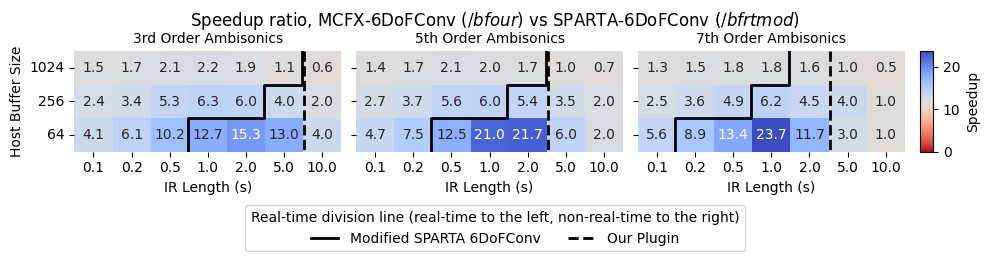

In [92]:
# Main execution
plt.close('all')
fig = create_performance_heatmap(moddedData, 
                                 asterisks=False, 
                                 colormap='coolwarm_r',
                                 rtlinesNew=[[6,6,6],[5,5,5],[5,5,5]],
                                 rtlinesOld=[[6,5,3],[5,4,2],[4,3,1]],
                                 labelOld='Modified SPARTA 6DoFConv', 
                                 labelNew='Our Plugin',
                                 title = f'Speedup ratio, MCFX-6DoFConv ({matplotlibbold('our')}) vs SPARTA-6DoFConv ({matplotlibbold('rtmod')})',
                                 titlesize = 12)

outfile = os.path.join('outplots','speedup_new_vs_modded')
fig.savefig(outfile+'.png', bbox_inches='tight')
fig.savefig(outfile+'.pdf', bbox_inches='tight')
fig.savefig(outfile+'.svg', bbox_inches='tight')
plt.show()

outplots\irtf_old


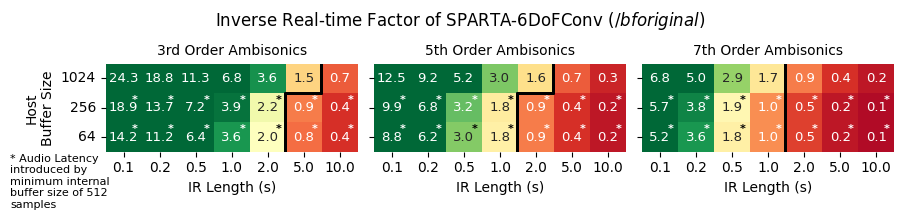

outplots\irtf_new


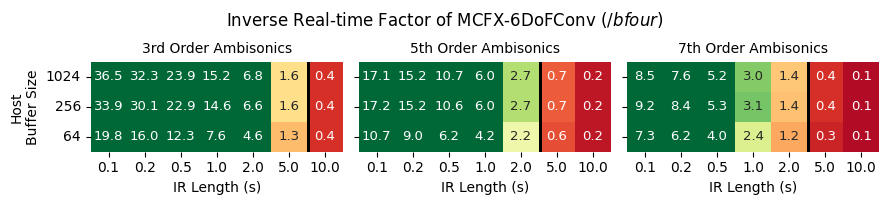

In [93]:
def create_irtf_minimal_heatmap(data, plugin, title=None, title_size=12, SCATTER=True, binarycmap=True, absolute_max=1.1, rtlinesOld=None, rtlinesNew=None,asterisks=False, asterisk_colors=None):
    channel_numbers = sorted(data['channels'].unique())
    buffer_sizes = sorted(data['spl'].unique())
    ir_lengths = sorted(data['irlen_s'].unique())
    ambisonics_orders = np.sqrt(channel_numbers)-1

    fig, axes = plt.subplots(1, len(channel_numbers), figsize=(9, 2.5), sharey=True)

    def get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths):
        scatter_x = [[] for _ in range(len(channel_numbers))]
        scatter_y = [[] for _ in range(len(channel_numbers))]
        scatter_color = [[] for _ in range(len(channel_numbers))]

        plottable = np.zeros((len(channel_numbers), len(buffer_sizes), len(ir_lengths)))
        for idx, channels in enumerate(channel_numbers):
            for idx2, buffer_size in enumerate(buffer_sizes):
                for idx3, ir_length in enumerate(ir_lengths):
                    plottable[idx, idx2, idx3] = data[(data['channels'] == channels) & (data['spl'] == buffer_size) & (data['irlen_s'] == ir_length) & (data['plugin'] == plugin)]['X_mean'].values[0]
                    scatter_x[idx].append(idx3) #ir_length)
                    scatter_y[idx].append(idx2) #buffer_size)
                    scatter_color[idx].append(plottable[idx, idx2, idx3])
        return plottable, (scatter_x,scatter_y,scatter_color)

    # Now, instead of computing the ratio, we plot a headmap for each of the plugins, and plot directly the values
    assert plugin in ['old','new'], 'plugin must be either "old" or "new"'
    plugindata, scatterplottables = get_plottable(data, plugin, channel_numbers, buffer_sizes, ir_lengths)
    
    if title:
        fig.suptitle(title, fontsize=title_size)
    for idx, order in enumerate(ambisonics_orders):
        # Extract data for specific ambisonics order
        data = plugindata[idx, :, :]
        
        round_to_next_half = lambda x: np.ceil(x*2)/2
        
        if SCATTER == True:
            colors = ['red' if p < 1 else 'green' for p in scatterplottables[2][idx]]

            # first plot only those with color red
            axes[idx].scatter([scatterplottables[0][idx][i] for i in range(len(scatterplottables[2][idx])) if scatterplottables[2][idx][i] < 1], 
                              [scatterplottables[1][idx][i] for i in range(len(scatterplottables[2][idx])) if scatterplottables[2][idx][i] < 1], 
                              c='red', s=100, marker='_')
            # then plot only those with color green
            axes[idx].scatter([scatterplottables[0][idx][i] for i in range(len(scatterplottables[2][idx])) if scatterplottables[2][idx][i] >= 1],
                              [scatterplottables[1][idx][i] for i in range(len(scatterplottables[2][idx])) if scatterplottables[2][idx][i] >= 1],
                              c='green', s=100, marker='+')
            
            # Set labels
            axes[idx].set_xlabel('IR Length (s)')
            # axes[idx].set_xticklabels(ir_lengths, rotation=0)

            borders = 0.5
            axes[idx].set_ylim(-borders,len(buffer_sizes)-1+borders)
            axes[idx].set_xlim(-borders,len(ir_lengths)-1+borders)

            if idx == 0:
                axes[idx].set_ylabel('Host\nBuffer Size')
            
            axes[idx].set_yticks(list(range(len(buffer_sizes))))
            axes[idx].set_yticklabels(buffer_sizes)

            axes[idx].set_xticks(range(len(ir_lengths)))
            axes[idx].set_xticklabels(ir_lengths)

            # Legend
            if idx == len(ambisonics_orders)-1:
                axes[idx].legend(['Non real-time','Real-time'], loc='center left', bbox_to_anchor=(1, 0.5))
        else:

            # Create heatmap
            dark_red = 'darkred'    # Dark red
            dark_green = 'green'  # Dark green
            colors = [dark_red, dark_green]
            from matplotlib.colors import ListedColormap
            binary_cmap = ListedColormap(colors)


            bbox_props = dict(boxstyle='square,pad=0.5',
                 ec='black',
                 fc='none',
                 linewidth=2)

            ccbar = False if binarycmap else (idx == len(ambisonics_orders)-1)
            sns.heatmap(data, 
                        ax=axes[idx], 
                        # cmap='RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
                        cmap=binary_cmap if binarycmap else 'RdYlGn',  # Red-Yellow-Green reversed (red = worse, green = better)
                        cbar=False, #ccbar, #idx == len(ambisonics_orders)-1,  # Only add colorbar to last subplot
                        annot=True, 
                        fmt='.1f',
                        # vmin=0.9, 
                        # vmax=round_to_next_half(max(oldPlugin_data.max(), oldPlugin_data.max())),
                        # center=5,
                        vmin=0.9 if binarycmap else 0, 
                        vmax=1.1 if binarycmap else absolute_max,
                        # center=6,
                        cbar_kws={'label': 'Real-time Ratio'} if idx == len(ambisonics_orders)-1 else {},
                        annot_kws={'size': 9.5, 
                                    'rotation': 0},
                        )
                        
            if rtlinesOld != None:
                draw_real_time_crosslines(axes, idx,rtlinesOld, linestyle='solid', xoffset=-0.03)
            if rtlinesNew != None:
                draw_real_time_crosslines(axes, idx,rtlinesNew, linestyle='solid', xoffset=0.03)
            
            if idx == 0:
                axes[idx].set_ylabel('Host\nBuffer Size')
            
            axes[idx].set_yticklabels(buffer_sizes, rotation = 0)
            axes[idx].invert_yaxis()
            axes[idx].set_xticklabels(ir_lengths)
            axes[idx].set_xlabel('IR Length (s)')

            if asterisks:
                draw_asteriscs_oldplugin_buffersize(ir_lengths,buffer_sizes,axes[idx], asterisk_colors=asterisk_colors[idx])

        axes[idx].set_title(f'{numeral_to_ordinal(int(order))} Order Ambisonics', size=PERPLOT_TITLE_SIZE)
    # plt.tight_layout(w_pad=0.5, h_pad=1)

    if asterisks:
        add_clipped_figtext(fig, 0, 0.18, "* Audio Latency introduced by minimum internal buffer size of 512 samples",width=0.2, height=0.22)

    
    fig.tight_layout(rect=[0, 0.18, 1, 1.05])


# Absolute max should contain the maximum X_mean value for all the data
absolute_max = data['X_mean'].max()
for idx,plugin in enumerate(['old','new']):
    create_irtf_minimal_heatmap(data,plugin, SCATTER=False, binarycmap=False,absolute_max=absolute_max//9,
                                   rtlinesNew=[[6,6,6],[5,5,5],[5,5,5]] if plugin == 'new' else None,
                                   rtlinesOld=[[6,5,5],[5,4,4],[4,4,4]] if plugin == 'old' else None,
                                   asterisks = plugin == 'old',
                                   asterisk_colors = ([['w','w','w','w','k','w','w'],['w','w','w','w','k','w','w']],
                                                      [['w','w','k','k','w','w','w'],['w','w','w','k','w','w','w']],
                                                      [['w','w','k','w','w','w','w'],['w','w','k','w','w','w','w']]),
                                   title="Inverse Real-time Factor of "+(f'SPARTA-6DoFConv ({matplotlibbold('original')})' if plugin == 'old' else f'MCFX-6DoFConv ({matplotlibbold('our')})'))
    outfile = os.path.join('outplots','irtf_%s'%plugin)
    print(outfile)
    plt.savefig(outfile+'.png', bbox_inches='tight')
    # plt.savefig(outfile+'.svg', bbox_inches='tight')
    plt.savefig(outfile+'.pdf', bbox_inches='tight')
    plt.show()

outplots\irtf_rtmod_SPARTA6dof


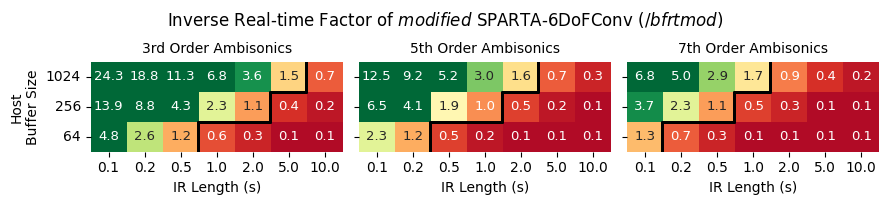

In [94]:
absolute_max = moddedData['X_mean'].max()
plugin = 'old'
create_irtf_minimal_heatmap(moddedData,plugin, SCATTER=False, binarycmap=False,absolute_max=absolute_max//9,
                               rtlinesOld=[[6,5,3],[5,4,2],[4,3,1]],
                               title=f"Inverse Real-time Factor of {matplotlibit('modified')} SPARTA-6DoFConv ({matplotlibbold('rtmod')})")
outfile = os.path.join('outplots','irtf_rtmod_SPARTA6dof')
print(outfile)
plt.savefig(outfile+'.png', bbox_inches='tight')
# plt.savefig(outfile+'.svg', bbox_inches='tight')
plt.savefig(outfile+'.pdf', bbox_inches='tight')
plt.show()
del plugin

,id,plugin,channels,irlen_s,spl,X_mean,X_std,inverse_ratio_mean,inverse_ratio_std
8,5,new,16,2.0,1024,6.85,0.070711,0.145993,0.001507
9,5,old,16,2.0,1024,3.65,0.070711,0.274024,0.005309
8,5,new,16,2.0,256,6.55,0.212132,0.152752,0.004947
9,5,old,16,2.0,256,2.15,0.070711,0.465368,0.015305
8,5,new,16,2.0,64,4.60,0.173205,0.217602,0.008375
9,5,old,16,2.0,64,2.00,0.000000,0.500000,0.000000


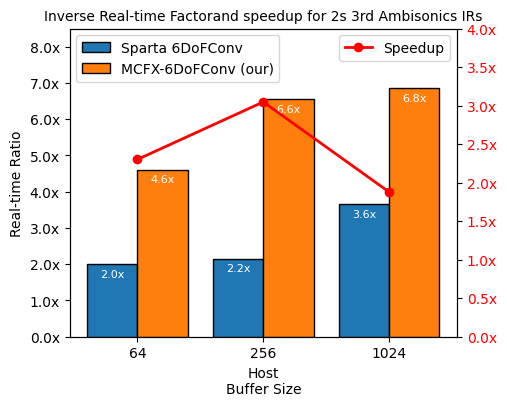

In [95]:
# def getextra_data():
#     extra_data = pd.read_csv('early_measurements_averaged.csv')
#     extra_data = extra_data[extra_data['irlen_s'] == 2]
#     # sort by spl
#     extra_data = extra_data.sort_values(by='spl')
#     buffer_sizes = extra_data['spl'].unique()
#     return extra_data, buffer_sizes, 2, 16, '3rd'

def getextra_data():
    # extra_data = data[data['irlen_s'] == 2 and data['channels'] == 16]
    extra_data = data[(data['irlen_s'] == 2) & (data['channels'] == 16)]
    display(extra_data)
    extra_data = extra_data.sort_values(by='spl')
    buffer_sizes = extra_data['spl'].unique()
    return extra_data, buffer_sizes, 2, 16, '3rd'



extra_data, buffer_sizes, irlen,channels, ambiorder = getextra_data()
X = buffer_sizes
ix = np.arange(len(X))
y1 = extra_data[extra_data['plugin'] == 'old']['X_mean']
y2 = extra_data[extra_data['plugin'] == 'new']['X_mean']

fig, ax = plt.subplots(figsize=(5, 4))
# ax.plot(X, y1, label='old')
# ax.plot(X, y2, label='new')
barwidth=0.4
bars_old = ax.bar(ix-barwidth/2.0,y1, label='Sparta 6DoFConv', width=barwidth, zorder=10,edgecolor='black')
# add text values
for i, (v,v2) in enumerate(zip(y1,y2)):
    ax.text(i-barwidth/2.0, v - 0.35, "%.1fx"%(v), color='white', ha='center', zorder=11, size=8)
    ax.text(i+barwidth/2.0, v2 - 0.35, "%.1fx"%(v2), color='white', ha='center', zorder=11, size=8)
bars_new = ax.bar(ix+barwidth/2.0,y2, label='MCFX-6DoFConv (our)', width=barwidth, zorder=10,edgecolor='black')
ax.set_xlabel('Host\nBuffer Size')
ax.set_ylim(0.0,8.5)
# ax.set_xticks(X)
ax.set_xticks(ix)
ax.set_xticklabels(X)



ax.set_ylabel('Real-time Ratio')
lowest_dot5_ceil = lambda x: np.ceil(x*2)/2

yticks = np.arange(ax.get_ylim()[0], #lowest_dot5_ceil(ax.get_ylim[0]),0),
                        ax.get_ylim()[1]+0.1,
                        1)
ax.set_yticks(yticks)
ax.set_yticklabels([str(e)+"x" for e in yticks])

ax.set_title('Inverse Real-time Factorand speedup for %ds %s Ambisonics IRs'%(irlen,ambiorder),size=PERPLOT_TITLE_SIZE)
ax.legend(loc='upper left')


ax2 = ax.twinx()
# ax2.grid(True, zorder=1)
ax2.plot(ix, np.array(y2)/np.array(y1), color='red', linewidth=2, label='Speedup', marker='o', zorder=10)
ax2.set_ylim(0.0,3.5)

# ax2.set_zorder(1)
# ax.set_zorder(1)


yticks = np.arange(ax2.get_ylim()[0], #lowest_dot5_ceil(ax.get_ylim[0]),0),
                        ax2.get_ylim()[1]+0.7,
                        0.5)
ax2.set_yticks(yticks)
ax2.set_yticklabels([str(e)+"x" for e in yticks], color='red')


ax2.legend(loc='upper right')

plt.show()


In [96]:
import os
readmetext = r"""
6DoF-SpatialAudioConvolver
---

This repository points to the source code for the __MCFX-6DoFConv__ plugin and contains the code for the performance comparison between the original SPARTA-6DoFConv plugin and the proposed MCFX-6DoFConv plugin.

## Plugin Source Code
The source code for the MCFX-6DoFConv plugin is contained in the submodule in `plugin/` (or [here](https://github.com/domenicostefani/SPARTA_Multi6DoF_project/tree/develop)).
Windows 64 plugin binaries [here](https://github.com/domenicostefani/SPARTA_Multi6DoF_project/releases/tag/MCFX-6DoFconv-1.0.0)

## Performance Comparison
Here we compare the performance of the following:
1. __SPARTA-6DoFConv__ (__original__ plugin, which is zero-latency only for buffer sizes >= 512)
2. __MCFX-6DoFConv__ (__our__ plugin with efficient convolution, always zero-latency)
3. __modified-SPARTA-6DoFConv__ (__rtmod__: plugin with lower buffer size cap to become zero-latency like ours, for fair comparison)


We measured computational efficiency by setting up REAPER projects with 63 configurations including different _host-buffer-sizes_, _IR lengths_, and _ambisonics order_ (num. channels).  
Measurements were performed on a 2020 Dell XPS 15 9500 laptop with the Windows 10 OS and an Intel(R) Core(TM) i7-10750H CPU, 6 cores, 12 logical processors, 32GB RAM.
Most background processes were disabled, including networking and bluetooth. 
Each plugin was hosted in a separate REAPER project with a single multichannel track, matching the ambisonics order of each IR configuration. 

For each configuration, we rendered a known-length input file in _fully offline_ mode with each plugin individually, and measure the time taken to render the file.  
Input audio file ranged from 5 minutes to 30 seconds depending on the configuration for the render time to be within a reasonable range, both for having a meaningful measurmement value and for the sake of time.  
It's worth noticing that the smallest input size of 30s is enough for both convolvers to reach a steady state where the tails of even the longest IRs are fully convolved along with early attach partitions.  

We report __Inverse Real-time Factor__ (iRTF) as the ratio between the duration of the input file and the render-time.
Inverse Real-time Factortherefore offers a proxy for the computational efficiency of the plugin, where a value of 1.0 indicates that the plugin can render the input file in real-time using the entire time allotted for the render.
Greater values indicate that the plugin is more computationally efficient, rendering the input file in less time than the duration of the input file, which would potentially allow for multiple instances of the plugin to run in real-time.
Smaller values indicate that the plugin cannot process in real-time for the given configuration on the test machine.

Finally, we report the __Speedup__ as the ratio between the iRTF of the proposed plugin over the iRTF of the original plugin.
It is equivalent to the inverse of the ratio between the render times of the two plugins.
A speedup of 1.0 indicates that the two plugins have the same computational efficiency, regardless of whether the configuration is rendered in real-time or not.

### Inverse Real-time Factor of __original__ SPARTA-6DoFConv plugin
`analysis/outplots/irtf_old.png`   
![](analysis/outplots/irtf_old.png)
Note that, because the inner convolver of the original plugin has a minimum buffer size of 512 samples, it can process faster than real-time in average, however it introduces latency in the audio processing with respect to the host buffer size (for sizes of 512 and smaller).

### Inverse Real-time Factor of the proposed MCFX-6DoFConv plugin
`analysis/outplots/irtf_new.png`   
![](analysis/outplots/irtf_new.png)
Note: zero-latency for all buffer sizes.

### Speedup ratio of MCFX-6DoFConv plugin with respect to SPARTA-6DoFConv plugin
`analysis/outplots/speedup_new_vs_old.png`   
![](analysis/outplots/speedup_new_vs_old.png)

### Modifying the original plugin for fair comparison
Despite the overall rt-ratio and speedup being in favor of the proposed plugin, they do not tell the whole story.
Since the old plugin caps the buffer size of the convolver to a minumum of 512 samples, it introduces latency in the audio processing.
While the plugin can process in real-time or faster __with respect to the inner (capped) buffer size_, it does not comply with the host buffer size (therefore the user's expected latency).
To have a fair comparison, we modified the original plugin to remove the lower buffer size cap of 512 samples.
As a consequence, zero-latency behavior is achieved, at the cost of increased number of partitions for the uniform partitioning scheme.
The results are as follows:

### Inverse Real-time Factor of __modified__ SPARTA-6DoFConv plugin
`analysis/outplots/irtf_rtmod_SPARTA6dof.png`   
![](analysis/outplots/irtf_rtmod_SPARTA6dof.png)

### Speedup ratio of MCFX-6DoFConv plugin with respect to __modified__ SPARTA-6DoFConv plugin
`analysis/outplots/speedup_new_vs_modded.png`   
![](analysis/outplots/speedup_new_vs_modded.png)


### Repository
Plots are in `analysis/outplots/`  
Source data csv files are in `analysis/` along with averages of the repeated measurements.  

The code for producing the plots is in
`analysis/plot.ipynb`  


`data/` contains screenshot of render times but you won't need them.  
`analysis/0-clean_data.py` contains the code used to clean up raw data csv's, check for potential transcription errors, and average repeated measures.  
`data/position_change_delay_measurements` contains Plogue Bidule project files for testing the CONTROL latency of the plugins (Namely the delay between the control message that changes listener position and the actual change of IR matrix reflected in the sound).


_Domenico Stefani, Jan 2025_
"""


readmepath = os.path.join('../','README.md')
assert os.path.exists(readmepath), 'README.md not found'
with open(readmepath,'w') as rf:
    rf.write(readmetext)